In [2]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
import tools4PytChem as t4p

**Start at:** Thursday 12 October 2023, 11:40:55  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

# Recurrent neural networks (RNN)

## General overview

<div class="intro">

The general architecure of an RNN and some variants is:
<img width="450" src="./DS4B-Slides/pngs/ZooNN/RNNfamily.png" style="display:block; margin-left:auto; margin-right:auto;" id="RNN"/> 

Let's continue with our "*top-down approach*", which consists in learning how to implement an algorithm before going back and covering the theory. An RNN is characterized by **direction of the flow of information between its layers**. As traditional NN, they utilize training data to learn. They are distinguished by their “memory” as they take information from prior inputs to influence the current input and output. While **traditional deep NN** assume that **inputs and outputs are independent of each other**, the output of recurrent neural networks depend on the prior elements within the sequence. Their ability to use internal state (memory) makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition, or any problem which exhibits temporal dynamic behavior, such as **molecular dynamics**.

Let's consider the trajectory of a ball in a 3D space. What we want at any time $t$ is to predict its new position at $t +\delta t$. Let's call the coordinates at time $t$:

$$[x_1(t), x_2(t), x_3(t)]$$

and

$$[\hat{x}_1(t +\delta t), \hat{x}_2(t +\delta t), \hat{x}_3(t +\delta t)]$$

the predicted ones at $t +\delta t$. In terms of "traditional" NN, we want:

<img width="10%" src="./ML-Figures/RNN_usualNN.png" style="display:block; margin-left:auto; margin-right:auto;" id="RNNtradNN"/>

that can be summarized as:

<img width="10%" src="./ML-Figures/RNN_usualNNsimp.png" style="display:block; margin-left:auto; margin-right:auto;" id="RNNtradNNsimp"/>

<br>

But what can't be done with a traditional NN is to take into account several instants of the ball’s motion, whereas RNNs can. **Recurrent** means the output at the *current* time step becomes the input to the *next* time step, but with information of the *previous* time step. In contrast with a classical neuron, a recurrent neuron can be schematized as:

<img width="650" src="./ML-Figures/Rneuron_vs_Cneuron.svg" style="display:block; margin-left:auto; margin-right:auto;" id="RNvsCN"/>

where the calculation of the output is given by

$y=\sigma\left(W_{x}^{T}X+b\right)$

for the classical neuron, and by

$y_{t}=\sigma\left(W_{x}^{T}X_{t}+w_{y}y_{t-1}+b_{t}\right)$

for the recurrent neuron
</div>
<br>
<div class="rqT" title="Warning!">

Don't make a confusion between back-propagation, a feedback mechanism of the training process, and this recurrent mechanism, that occurs during the application of an already trained RNN.
    
</div>
<br>
<div class="intro">

RNNs are actually more complicated than this simple scheme. They must be seen as fully recurrent neural networks, which connect the outputs of all neurons to the inputs of all neurons, as illustrated below. What appears to be layers are, in fact, different time steps of the same fully recurrent neural network.

<img width="650" src="./ML-Figures/RNN_unfold.svg" style="display:block; margin-left:auto; margin-right:auto;" id="FRNN"/>
    
</div>

<div class="intro">
    
But the major drawback of an RNN is that it has a short-term memory, like a **goldfish**

<img width="200" src="./ML-Figures/Goldfish-DallE.png" style="display:block; margin-left:auto; margin-right:auto;" id="goldfish"/>

<br>LSTM (Long Short Term Memory) RNNs were proposed to introduce a long-term memory in addition the short-term memory of a standard RNN. LSTM is normally augmented by recurrent gates called "forget gates". LSTM prevents backpropagated errors from vanishing or exploding. LSTM can learn tasks that require memories of events that happened thousands or even millions of discrete time steps earlier. An LSTM unit looks like

<img width="650" src="./ML-Figures/LSTM.svg" style="display:block; margin-left:auto; margin-right:auto;" id="LSTM"/>

<br>Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks introduced in 2014. They are used in the full form and several simplified variants. They have fewer parameters than LSTM, as they lack an output gate. A GRU unit can be schematized as

<img width="650" src="./ML-Figures/GRU.svg" style="display:block; margin-left:auto; margin-right:auto;" id="GRU"/>
</div>

## Prediction of a ladybug 2D trajectory via an RNN

<div style="intro">
    
**Adaptation of a fidle notebook**

<a href="https://fidle.cnrs.fr/"><img width="200" src="./ML-Figures/00-Fidle-logo-01.svg"></img></a>

<img width="200" src="./ML-Figures/Ladybug-DallE.png" style="display:block; margin-left:auto; margin-right:auto;" id="ladybug"/>

</div>

### Initialization

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

2023-10-12 11:40:57.772643: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 11:40:57.789263: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 11:40:57.936909: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 11:40:57.938099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 11:40:59.430072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Generation of the datasets

#### Calculation of the coordinates

<div class="intro">

The movement of the ladybird will be given by these two trigonometric relations, that depend on 8 parameters

$x_{t}=a_{x1}\sin\left[(k_{x1}+20)t\right]+a_{x2}\cos\left[(k_{x2}+10)t\right]+a_{x3}\sin\left[(k_{x3}+5)t\right]+a_{x4}\cos\left[(k_{x4}+5)t\right]$

$y_{t}=a_{y1}\cos\left[(k_{y1}+20)t\right]+a_{y2}\sin\left[(k_{y2}+10)t\right]+a_{y3}\cos\left[(k_{y3}+5)t\right]+a_{y4}\sin\left[(k_{y4}+5)t\right]$



</div>

In [4]:
def ladybug_init(s=123):
    import random
    
    if s>0 : random.seed(s)
    ladybug_init.params_x = [ random.gauss(0.,1.) for u in range(8)]
    ladybug_init.params_y = [ random.gauss(0.,1.) for u in range(8)]
    
def ladybug_move(t):
    import numpy as np
    k=0.5
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = ladybug_init.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init.params_y
    
    x = ax1*np.sin(t*(kx1+20)) + ax2*np.cos(t*(kx2+10)) + ax3*np.sin(t*(kx3+5)) + ax4*np.cos(t*(kx4+5))
    y = ay1*np.cos(t*(ky1+20)) + ay2*np.sin(t*(ky2+10)) + ay3*np.cos(t*(ky3+5)) + ay4*np.sin(t*(ky4+5)) 

    return x,y

In [5]:
max_t        = 1000
delta_t      = 0.02

# ---- Get positions
#
ladybug_init(s=16)
x,y = 0,0
positions=[]
for t in np.arange(0., max_t, delta_t):
    x,y = ladybug_move(t)
    positions.append([x,y])
    
print(f"Number of coordinates = {len(positions)}")

Number of coordinates = 50000


#### Plots

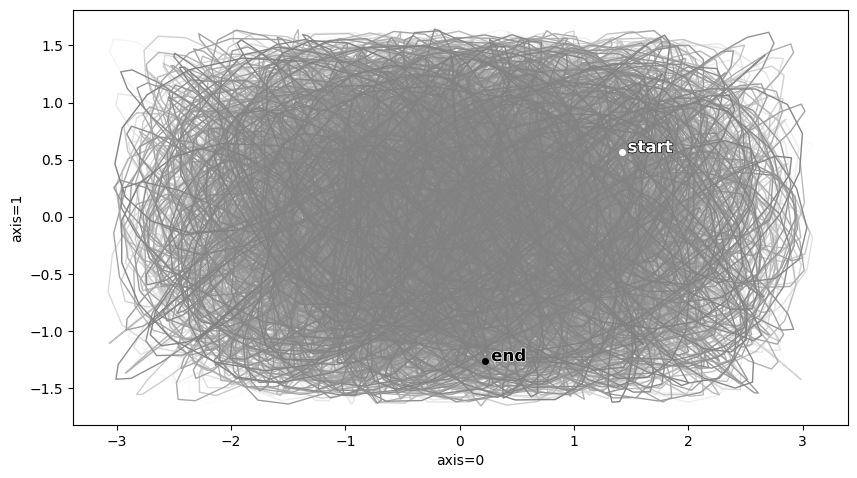

In [6]:
def traj2D(data, figsize=(10,8), monocolor=False, hide_ticks=True, lw=1, ms=4, save_as='auto'):
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    """
    Plot a 2d dataset as a trajectory
    args:
        data:      Dataset to plot
        figsize:   Figure size ( (10,8))
        monocolor: Monocolor line or not. (False)
    return:
        nothing
    adapted from the fidle.scrawler.serie_2d function
    author: Jean-Luc Parouty CNRS/MIAI/SIMaP 2022
    """
    # ---- Get x,y, min and max
    #
    n     = len(data)
    k     = int(n/100)
    x,y   = data[:,0], data[:,1]
 
    # ---- Draw it
    #
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()

    # ---- Monocolor or gray gradient
    #
    if monocolor:
        ax.plot(x,y)
    else:
        for i in range(0,100):
            a= (200-i)/200
            ax.plot(x[i*k:(i+1)*k+1], y[i*k:(i+1)*k+1], '-', color=(a,a,a),lw=lw,zorder=1)

    # ---- First point
    #
    ax.plot(x[0], y[0], 'o', color='#ffffff',markersize=ms,zorder=2)
    txt = ax.annotate('start', xy=(x[0]+0.05, y[0]), fontsize=12, color='#ffffff',weight="bold")
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='#000000')])
    # ---- Last point
    #
    ax.plot(x[n-1], y[n-1], 'o', color='#000000',markersize=ms,zorder=2)
    txt = ax.annotate('end', xy=(x[n-1]+0.05, y[n-1]), fontsize=12, color='#000000',weight="bold")
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='#ffffff')])
    
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('axis=0')
    ax.set_ylabel('axis=1')
    
    if hide_ticks:
        ax.set_yticks([])
        ax.set_xticks([])

    #save_fig(save_as)
    plt.show()

t4p.centerTitle(f"Full data set ({len(positions)} trajectory data)")
full_dataset = np.array(positions)
traj2D(full_dataset,monocolor=False,hide_ticks=False)

(50000, 2)


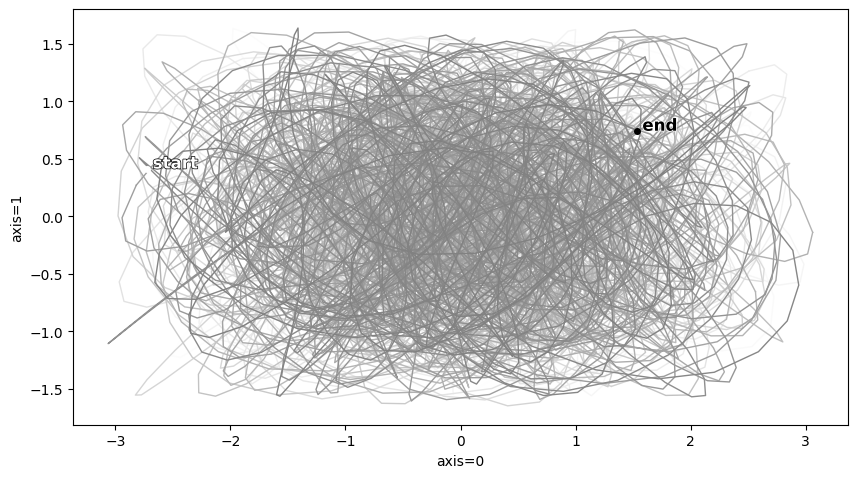

In [7]:
import random
select = 0.2 #fraction of the dataset that will be used for the ML workflow (1=all)
print(full_dataset.shape)
n = int(full_dataset.shape[0]*select)
i = random.randint(0, full_dataset.shape[0] - n)
dataset = np.array(full_dataset[i:i+n])

t4p.centerTitle(f"data set for ML workflow = t({i}-{i+n}) trajectory data")
traj2D(dataset,monocolor=False,hide_ticks=False)

#### Generation of the training and test sets with the hold-out method

<div class="intro">

Now let's generate the training and test sets. It's called the **hold-out** method. It involves splitting the data into multiple parts and using one part for training the model and the rest for validating and testing it.

<img width="450" src="./DS4B-svg/Basic-holdout-English.svg" style="display:block; margin-left:auto; margin-right:auto;" id="holdout"/>
</div>

mean after standard scaler = -0.00
stdd after standard scaler = 1.00


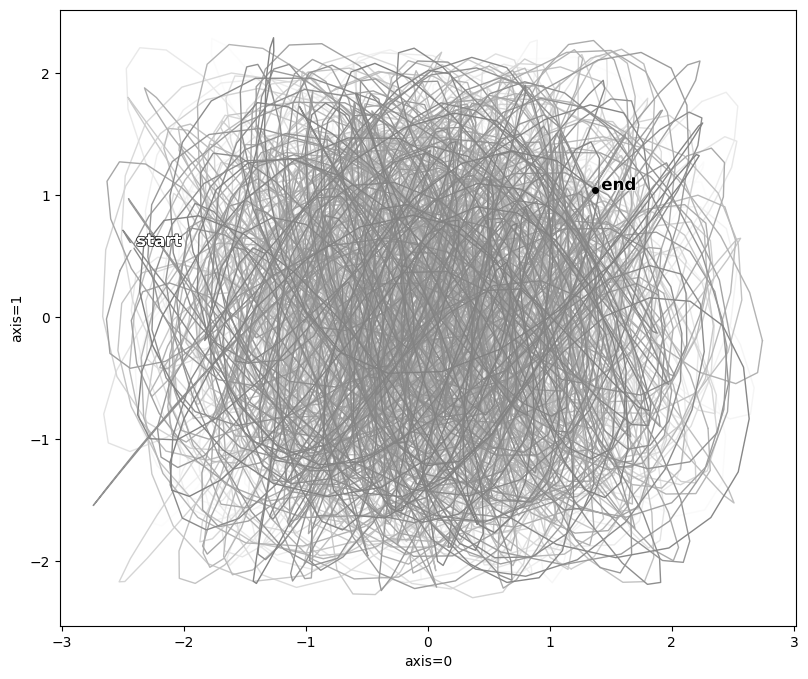

In [7]:
split_value = 0.8
ntrain = int(len(dataset)*split_value)
x_train = dataset[:ntrain]
x_test  = dataset[ntrain:]

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)
mean = x_train.mean()
stdd = x_train.std()
print(f"mean after standard scaler = {mean:.2f}")
print(f"stdd after standard scaler = {stdd:.2f}")

dataset_scaled = np.concatenate((x_train,x_test))
t4p.centerTitle(f"data set for ML workflow = t({i}-{i+n}) trajectory data after scaling")
traj2D(dataset_scaled,monocolor=False,hide_ticks=False)

### RNN model

#### A word about time sequences

<div class='intro'>

LSTM or GRU recurrent neural networks are capable of learning and remembering over long sequences of inputs. Using a long sequence data as-is without change may result in the problem of very long training times.
More troubling, attempting to back-propagate across very long input sequences may result in vanishing gradients, and in turn, an unlearnable model. A reasonable limit of **250-500 time steps** is often used in practice with large LSTM models.

Two key variables will be used:

`sequence_len` = number of times steps used for predicting the value of the `sequence_len + 1` time step

`predict_len` = prediction length = number of times steps **after a time sequence**

</div>

In [8]:
def traj2D_real_vs_pred(sequence_real, sequence_pred, pos, figsize=(10,8), ms=6, lw=1, hide_ticks=True, save_as='auto'):
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    """
    Plot a 2d segment real and predicted
    args:
        sequence_real: Real sequence (length: nreal+npred)
        sequence_pred: Predicted sequence (length: npred)
        pos:           Actual first time position of the real sequence
        figsize:       Figure size (default: (10,8) )
        ms:            Marker size (default: 6)
        lw:            Line width (default: 1)
        hide_ticks:    Do not show x and y ticks if False (default: True)
    return:
        nothing
    adapted from the fidle.scrawler.segment_2d function
    author: Jean-Luc Parouty CNRS/MIAI/SIMaP 2022
    """

    kp = len(sequence_pred)
    kr = len(sequence_real) - kp
    
    x,y = sequence_real[:,0],sequence_real[:,1]
    u,v = sequence_pred[:,0],sequence_pred[:,1]

    print(f"Length of the real sequence      = {len(sequence_real)} = {kr} + {kp} (predicted part)")
    print(f"Length of the predicted sequence = {len(sequence_pred)}")
    
    fig = plt.figure(figsize=figsize)

    ax = plt.axes()
    
    # ---- Draw real sequence without prediction
    #
    ax.plot(x[:kr], y[:kr],   'o', color='C0', fillstyle='full', zorder=2, ms=ms)
    ax.plot(x[:kr], y[:kr],   '-', color='C0', lw=lw, zorder=1)
    txt = ax.annotate(pos, xy=(x[0]+0.05, y[0]), fontsize=10, color='C0',weight="normal")
    txt = ax.annotate(pos+kr, xy=(x[kr-1]+0.05, y[kr-1]), fontsize=10, color='C0',weight="normal")
    
    # ---- What we expect
    #
    ax.plot(x[-kp:], y[-kp:], 'o', ms=ms, markeredgecolor='C0', markerfacecolor='white', zorder=2)
    ax.plot(x[-kp-1:], y[-kp-1:], '--', color='C0', lw=lw, zorder=1) #(-kp-1) to include segment between real and predicted

    # ---- What we have
    #
    ax.plot(u, v, 'o',  color='C1',fillstyle='full',zorder=2, ms=ms) #markers
    ax.plot( [x[-1-kp],u[0]], [y[-1-kp],v[0]], '--', color='C1',lw=lw, zorder=1) #segment between real and predicted results
    ax.plot(u, v, '-.', color='C1',lw=lw, zorder=1) #line
    txt = ax.annotate(pos+kr+kp, xy=(u[kp-1]+0.05, v[kp-1]), fontsize=10, color='C1',weight="normal")

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('axis=0')
    ax.set_ylabel('axis=1')
    
    if hide_ticks:
        ax.set_yticks([])
        ax.set_xticks([])

    # save_fig(save_as)
    plt.show()

Length of the real sequence      = 25 = 20 + 5 (predicted part)
Length of the predicted sequence = 5


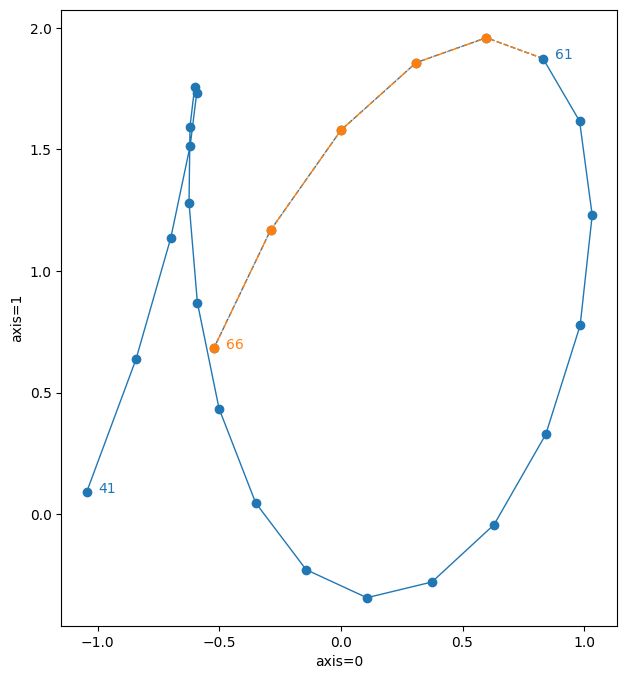

In [9]:
import random

sequence_len = 20
predict_len  = 5

ireal = random.randint(0,len(x_test) - sequence_len - predict_len)
freal = ireal + sequence_len

traj2D_real_vs_pred(x_test[ireal:freal+predict_len], x_test[freal:freal+predict_len], ireal, hide_ticks=False)

#### Definition of the model

<div class="intro">

Let's use a GRU (see the [documentation for the GRU class of Keras](https://keras.io/api/layers/recurrent_layers/gru/))

<img width="400" src="./ML-Figures/GRUonly.svg" style="display:block; margin-left:auto; margin-right:auto;" id="GRU"/> 
</div>

In [10]:
features_len = 2 #x and y coordinates

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sequence_len, features_len)),
    keras.layers.GRU(200, return_sequences=False, activation='relu'),
    keras.layers.Dense(features_len)
])
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

2023-10-11 15:03:04.460770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200)               122400    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 122802 (479.70 KB)
Trainable params: 122802 (479.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Training

<div class="intro">

`TimeseriesGenerator ` is a utility class for generating batches of temporal data. It is useful to easily handle time series. Let's play a bit with it. Consider a simple univariate time series: f(t) = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], i.e. a regular augmentation of this property f. `TimeSeriesGenerator` basically embeds the time series inside a `TimeSeriesGenerator` object that will later directly be feed inside the keras/tensorflow network

</div>

In [11]:
train = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
batch_sizeT = 3
sequence_lenT = 1
strideT = 1
generator = TimeseriesGenerator(train, train,stride=strideT, length=sequence_lenT, batch_size=batch_sizeT)
print(f'Number of batch trains available : {len(generator)}')
for i in range(len(generator)):
    print(f"Batch {i}. {generator[i]}")

Number of batch trains available : 4
Batch 0. (array([[0],
       [1],
       [2]]), array([1, 2, 3]))
Batch 1. (array([[3],
       [4],
       [5]]), array([4, 5, 6]))
Batch 2. (array([[6],
       [7],
       [8]]), array([7, 8, 9]))
Batch 3. (array([[ 9],
       [10],
       [11]]), array([10, 11, 12]))


<div class="intro">

- `data` and `targets` are basically what the network will use
- `length` is the length of each sequence used to train our network
- `stride` is the period between each record in your original data
- `batch_size` represents the number of sub-series per batch

You can play a bit with these values to see the changes
</div>

In [12]:
batch_size    = 32
epochs        = 15
fit_verbosity = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

# ---- Train generator
#
train_generator = TimeseriesGenerator(x_train, x_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test,  length=sequence_len,  batch_size=batch_size)

In [13]:
import os

dirModels = './ML-SavedModels/'
os.makedirs(dirModels,   mode=0o750, exist_ok=True)
save_path = dirModels + 'ladybug_best_model.tf'

bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, verbose=0, save_best_only=True)

In [14]:
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )

vID.chrono_start()

history=model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

vID.chrono_show()

Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 0.1200 - mae: 0.2371INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 9s 28ms/step - loss: 0.1200 - mae: 0.2371 - val_loss: 0.0113 - val_mae: 0.0879
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 0.0133 - mae: 0.0917INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 7s 29ms/step - loss: 0.0133 - mae: 0.0917 - val_loss: 0.0075 - val_mae: 0.0700
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0674INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 7s 26ms/step - loss: 0.0072 - mae: 0.0674 - val_loss: 0.0067 - val_mae: 0.0677
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0535INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 6s 26ms/step - loss: 0.0045 - mae: 0.0535 - val_loss: 0.0035 - val_mae: 0.0516
Epoch 5/15
250/250 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0446INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 7s 29ms/step - loss: 0.0033 - mae: 0.0446 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 6/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0026 - mae: 0.0398 - val_loss: 0.0018 - val_mae: 0.0330
Epoch 7/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0022 - mae: 0.0374 - val_loss: 0.0040 - val_mae: 0.0535
Epoch 8/15
250/250 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0349INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 7s 29ms/step - loss: 0.0020 - mae: 0.0349 - val_loss: 0.0010 - val_mae: 0.0253
Epoch 9/15
250/250 [==============================] - 6s 22ms/step - loss: 0.0017 - mae: 0.0319 - val_loss: 0.0033 - val_mae: 0.0523
Epoch 10/15
250/250 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0306INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 7s 27ms/step - loss: 0.0015 - mae: 0.0306 - val_loss: 5.6452e-04 - val_mae: 0.0194
Epoch 11/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0014 - mae: 0.0296 - val_loss: 5.9269e-04 - val_mae: 0.0186
Epoch 12/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0013 - mae: 0.0283 - val_loss: 0.0020 - val_mae: 0.0378
Epoch 13/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0012 - mae: 0.0276 - val_loss: 7.3228e-04 - val_mae: 0.0221
Epoch 14/15
250/250 [==============================] - 6s 22ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 9.3407e-04 - val_mae: 0.0254
Epoch 15/15
250/250 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0253INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


INFO:tensorflow:Assets written to: ./ML-SavedModels/ladybug_best_model.tf/assets


250/250 [==============================] - 7s 30ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 4.7982e-04 - val_mae: 0.0166

Duration :  00:01:37 868ms


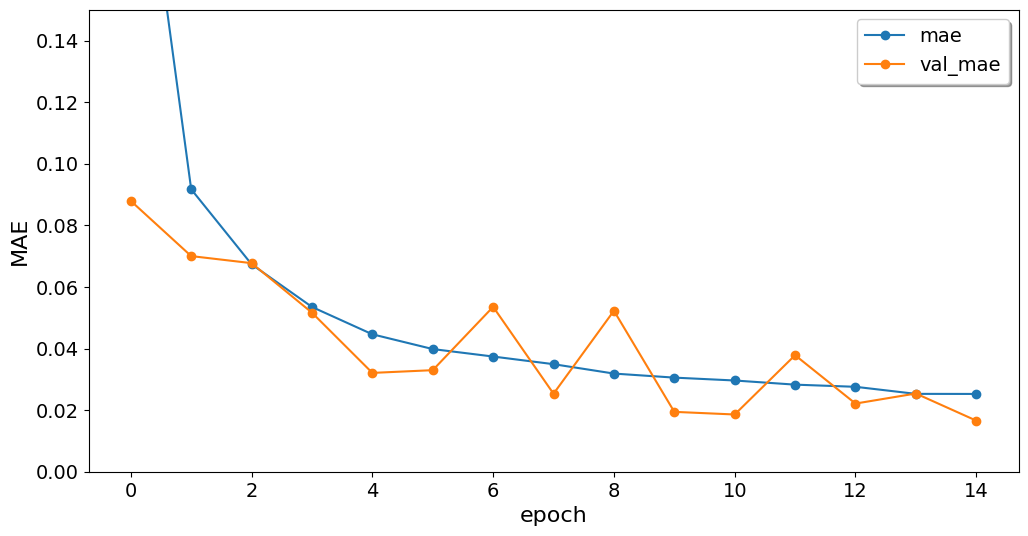

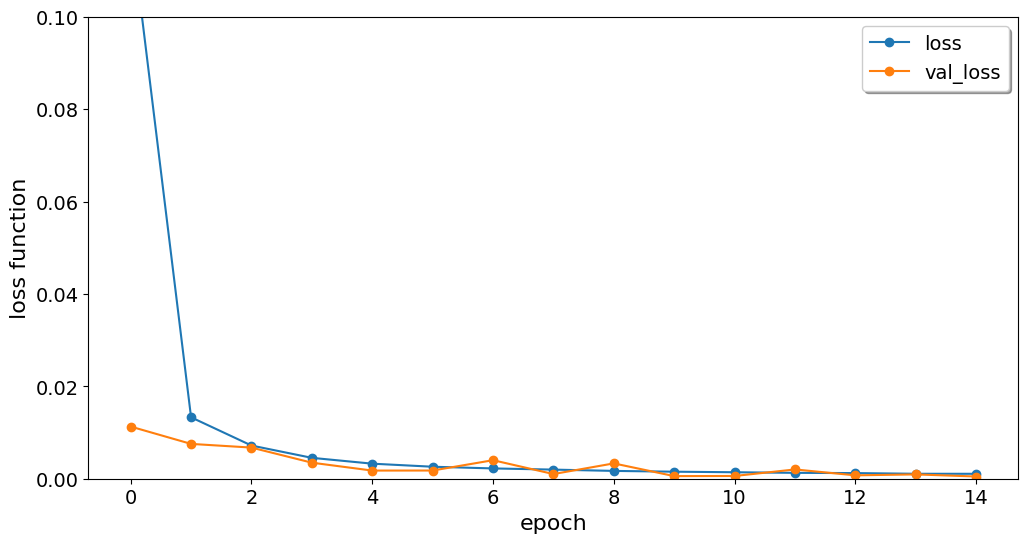

In [16]:
def plotHistory(history,prop,ylabel,ymax=0.1):
    import matplotlib.pyplot as plt
    import pandas as pd
    df=pd.DataFrame(data=history.history)
    plt.rcParams["figure.figsize"] = (12,6)
    figMAE=df.plot(y=prop,linestyle='-', marker='o',fontsize=14)
    figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
    figMAE.set_ylabel(ylabel,fontdict={'fontsize':16})
    figMAE.set_ylim([0,ymax])
    figMAE.legend(loc='upper right', shadow=True, fontsize='14')

plotHistory(history,["mae","val_mae"],"MAE",0.15)
plotHistory(history,["loss","val_loss"],"loss function",0.1)

### Prediction

#### Load the best model

In [8]:
loaded_model = tf.keras.models.load_model(save_path)
print('Best model loaded.')

NameError: name 'save_path' is not defined

#### Make a 1-step prediction on the test set

1/1 [==============================] - 0s 316ms/step
[[-0.18241009 -0.60330695]]
sequence shape      : (20, 2)
sequence true shape : (21, 2)
sequence pred shape : (1, 2)
Length of the real sequence      = 21 = 20 + 1 (predicted part)
Length of the predicted sequence = 1


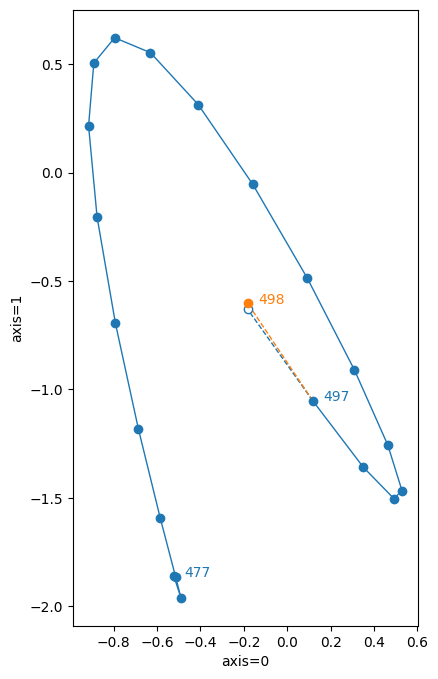

In [18]:
s = random.randint(0,len(x_test)-sequence_len)

predict_len = 1
sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len + predict_len]

sequence_pred = loaded_model.predict( np.array([sequence]) )
print(sequence_pred)

print('sequence shape      :',sequence.shape)
print('sequence true shape :',sequence_true.shape)
print('sequence pred shape :',sequence_pred.shape)

traj2D_real_vs_pred(sequence_true, sequence_pred, s, hide_ticks=False)

#### Make an *n*-step prediction

<div class="intro">

We need to build a function that will progressively shift the sequence window used for  prediction

<img width="700" src="./ML-Figures/RNN_unfold-timesSteps.svg" style="display:block; margin-left:auto; margin-right:auto;" id="FRNN"/>
</div>


1/1 [==============================] - 0s 21ms/step
sequence shape      : (20, 2)
sequence true shape : (25, 2)
sequence pred shape : (5, 2)
Length of the real sequence      = 25 = 20 + 5 (predicted part)
Length of the predicted sequence = 5


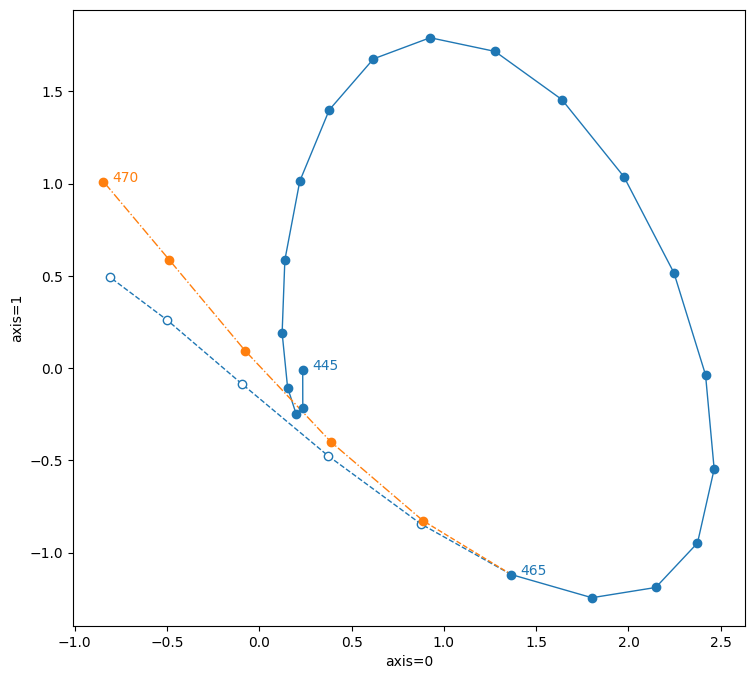

In [76]:
def get_nPredictions(model,sequence0,npredict=5):
    import numpy as np
    seqLen = len(sequence0)
    prediction = []
    # print(seqLen)
    # print(sequence0)
    print()
    for i in range(npredict):
        # t4p.centerTitle(f"iteration {i}")
        if (prediction):
            # print(sequence0)
            sequence = list(sequence0.copy()) + prediction
        else:
            sequence = list(sequence0.copy())
        # print(np.array(sequence))
        p = model.predict(np.array([sequence[-seqLen:]]))
        # print(p,'      ',p[0])
        prediction.append(p[0])
    # print()
    # print(prediction)
    return np.array(prediction)

s = random.randint(0,len(x_test)-sequence_len)

predict_len = 5
sequence0     = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len + predict_len]
sequence_pred = get_nPredictions(loaded_model,sequence0,predict_len)

print('sequence shape      :',sequence.shape)
print('sequence true shape :',sequence_true.shape)
print('sequence pred shape :',sequence_pred.shape)

traj2D_real_vs_pred(sequence_true, sequence_pred, s, hide_ticks=False)

# Useful links

[Recurrent Neural Networks by Example in Python, by *Will Koehrsen* (2018)](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)

[Wikipedia page on RNNs](https://en.wikipedia.org/wiki/Recurrent_neural_network)

[Hands-on machine learning with scikit-learn, keras and tensorflow (3rd edition, **2022**), Aurélien Géron, O'Reilly editions](https://github.com/ageron/handson-ml3)

Some images were generated with [DALL·E](https://openai.com/dall-e-2)

In [117]:
vID.end(cwd0)

**End at:** Sunday 08 October 2023, 21:22:10  
**Duration:** 01:19:44 625ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>